In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Loading the MNIST datasets
# 60000 images for training and 10000 images for testing
(image_train, label_train), (image_test, label_test) = tf.keras.datasets.mnist.load_data()
# Splitting the training set into 2: 55000 images for training and 5000 images for validation
image_valid = image_train[55000:]
label_valid = label_train[55000:]
image_train = image_train[:55000]
label_train = label_train[:55000]

0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0  

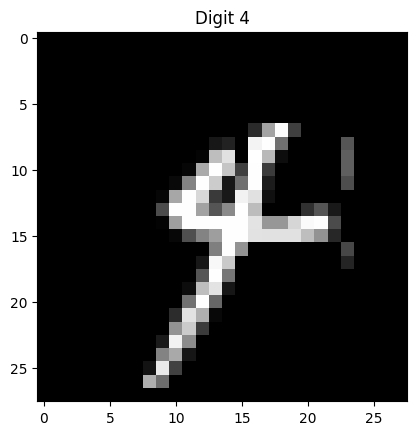

In [13]:
idx = 53
# Visualizing image array
image_arr = ""
for row in image_train[idx]:
    for col in row:
        if(len(str(col)) == 1):
            print(str(col) + "   ", end =" ")
            image_arr += str(col) + "   "
        elif(len(str(col)) == 2):
            print(str(col) + "  ", end =" ")
            image_arr += str(col) + "  "
        else:
            print(str(col) + " ", end =" ")
            image_arr += str(col) + " "
    print()
    image_arr += "\n"
with open("./test/image_arr.txt", "w") as file:
    file.write(image_arr)
# Plotting an image
plt.title(f"Digit {label_train[idx]}")
# Gray image
plt.imshow(image_train[idx], cmap='gray')
plt.savefig("./test/digit_grey.jpg")
# Black white
# plt.imshow(image_train[idx], cmap='binary') 
# plt.savefig("./test/digit_bw.jpg")

In [5]:
# Setting up the neural network architecture and hyperparameters
input_layer = 784  # input layer (28x28 pixels)
hidden_layer1 = 512  # 1st hidden layer (14x14 pixel)
hidden_layer2 = 256  # 2nd hidden layer
hidden_layer3 = 128  # 3rd hidden layer
output_layer = 10  # output layer (0-9 digits)

learning_rate = 1e-4
n_iterations = 1000
batch_size = 128
dropout = 0.5